Can we use the EG Uma spectrum to measure the Lya line?

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
spath = 'hst_spectra/eg_uma_COS_FUV_1291_2017-12-05.dat'
w, f, e, dq=  np.loadtxt(spath, unpack=True)
w, f, e = w[dq==0], f[dq==0], e[dq==0]

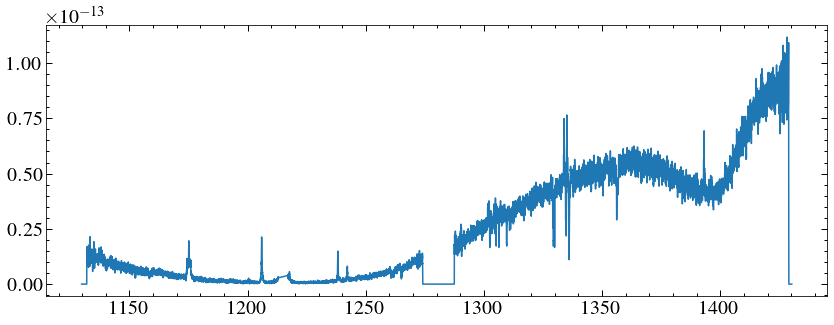

In [3]:
smooth=5
f = convolve(f,Box1DKernel(smooth))
e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
#plt.plot(w,f)
#plt.xlim(1210, 1220)
mask = (w < 1213) | (w > 1217)
wl, fl, el = w, f, e #retain to plot airglow
w, f, e = w[mask], f[mask], e[mask]
plt.plot(w,f)
#plt.xlim(1210, 1220)


In [4]:
lya = fits.getdata('hlsp_muscles_model_lya-reconstruction_gj1214_na_v22_component-spec.fits', 1)
g140m = fits.getdata('hlsp_muscles_hst_stis_gj1214_g140m_v22_component-spec.fits', 1)

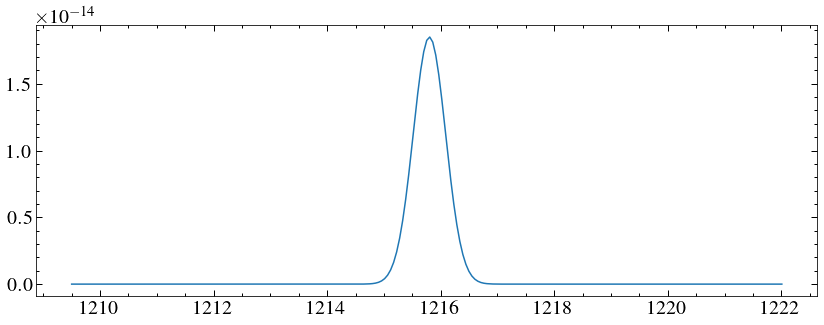

In [5]:
plt.plot(lya['WAVELENGTH'], lya['FLUX'])

In [6]:
#distance scale
p_eg = 34.83367384548251e-3
p_gj = 68.26534018946352e-3
scale = (p_eg/p_gj)**2
print(1/p_eg, 1/p_gj)
print(scale)

28.707853338578794 14.648722136659709
0.26037425760309946


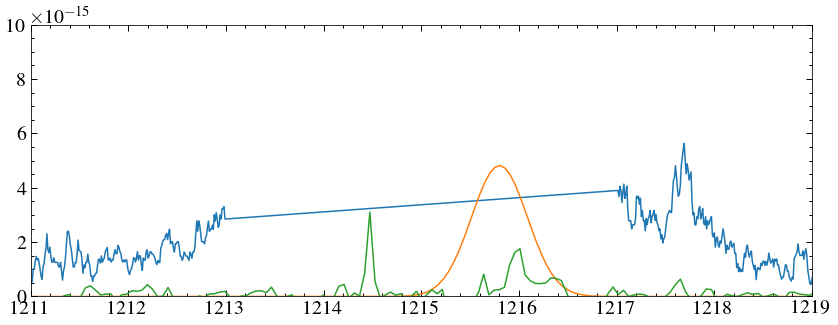

In [7]:
plt.plot(w,f)
plt.plot(lya['WAVELENGTH'], lya['FLUX']*scale)
plt.xlim(1211, 1219)
plt.ylim(0, 0.1e-13)
plt.plot(g140m['WAVELENGTH'], g140m['FLUX']*scale)

In [8]:
rv = -29 + -125.9


In [9]:
lyalam = 1215.67
newlam = (rv*u.km/u.s).to(u.AA, equivalencies=u.doppler_optical(lyalam*u.AA))
print(newlam)

1215.0418745152688 Angstrom


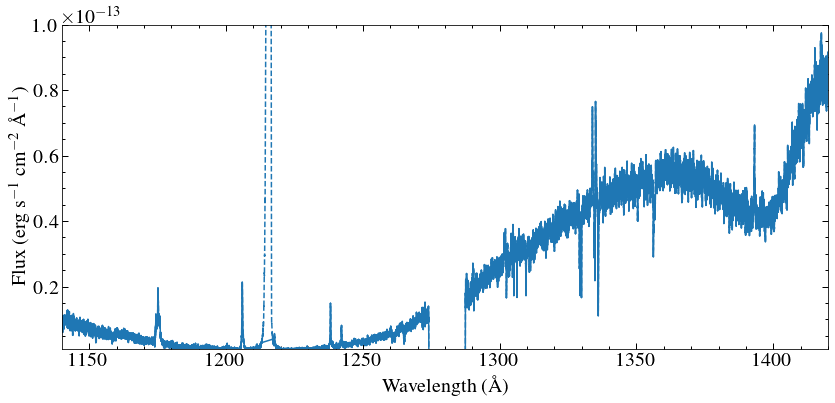

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(w,f)
plt.plot(wl,fl, ls='--', c='C0', zorder = -1)
plt.ylim(0.1e-14, 1e-13)
plt.xlim(1140, 1420)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.tight_layout()
#plt.savefig('plots/eg_uma_cos.png')

In [16]:
#model
mw, mf = np.loadtxt('models/DA_EG-UMA.dk', unpack=True, skiprows=34)

(1100.0, 1500.0)

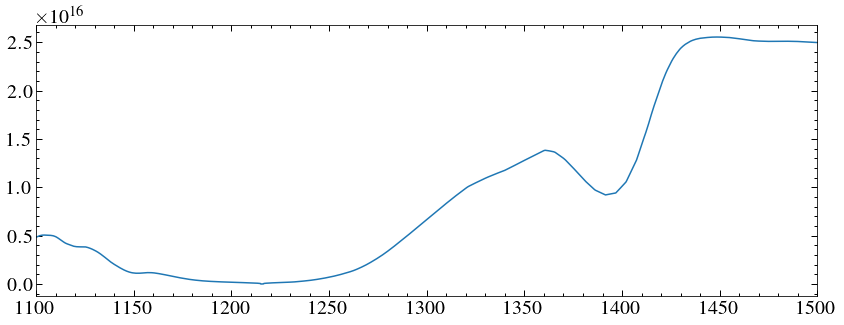

In [41]:

plt.plot(mw, mf)
plt.xlim(1100, 1500)

In [32]:
from scipy.optimize import leastsq


def residuals(scale, f, mf):
    return f - mf/scale


In [33]:
mmask = (mw > w[0]) & (mw < w[-1])
mw1, mf1 = mw[mmask], mf[mmask]

mf1 = interp1d(mw1, mf1, fill_value='extrapolate')(w)
normfac = leastsq(residuals, 1., args=(f, mf1))[0]

print(normfac)

[2.51732437e+29]


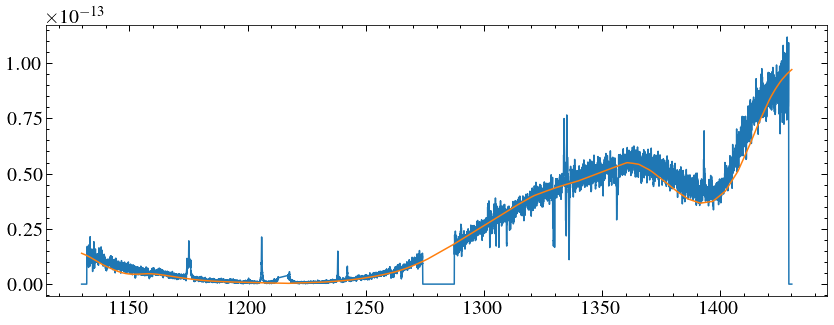

(0.0, 3.897208422623074e-14)

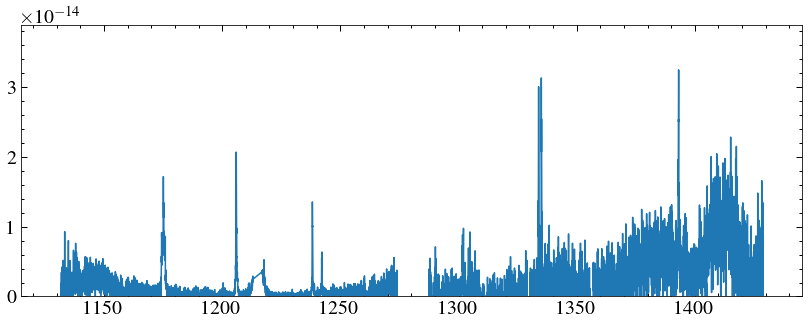

In [43]:
plt.plot(w,f)
plt.plot(w, mf1/normfac)
plt.show()

f2 = f-(mf1/normfac)

plt.plot(w, f2)
plt.ylim(0)
#plt.yscale('log')